In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


### Define functions used throughout the experiments

In [2]:
def generateX(n):
    x = np.random.uniform(-2.25, 2.25, n)
    return(x)

def generateLinearY(x, beta, b, sigma):
    n = len(x)
    eps = np.random.randn(n)
    y = beta*x + b + eps*sigma
    return y


def generateNonlinearY(x, sigma):
    def s(x):
        g = [1 if x[i] > 0 else abs(x[i])**2 + 1 for i in range(len(x))]
        return np.array(g)

    n = len(x)
    eps = np.random.randn(n) 
    y = 1.5*np.maximum(x, 0) + sigma * s(x) * eps
    return y


def splitData(x, y, n1):
    x1 = x[:n1]
    y1 = y[:n1]
    x2 = x[n1:]
    y2 = y[n1:]
    return x1, y1, x2, y2


In [3]:
def linearPredictionInterval(xtrain, ytrain, xnew, alpha):
    xtrain = xtrain.reshape(-1, 1)
    n1 = xtrain.shape[0]
    
    res = LinearRegression().fit(xtrain, ytrain)

# fit beta_hat
    betahat = res.coef_
    bhat = res.intercept_
# estimate of noise variance sigma_hat
    sigmahat = np.sqrt( np.sum((ytrain - xtrain @ betahat - bhat)**2)/(n1-2) )

    xtilde = np.hstack([xtrain, np.ones((n1, 1))])
    xtx = xtilde.T @ xtilde
    
    yhat = xnew*betahat + bhat # mean
    t = stats.norm.ppf(1-alpha/2) # -1.96,  1.96
    xnew1 = np.hstack([xnew.reshape(-1,1), np.ones((len(xnew), 1))])

    mat = xnew1 @ np.linalg.inv(xtx) @ xnew1.T    
    s = sigmahat*np.sqrt(1 + mat.diagonal())
    # s is the sd of y_new, var = sigma_hat^2 * (1 + x_new (X^TX)^{-1} x_new)
    
    return np.hstack([(yhat - t*s).reshape(-1, 1), (yhat + t*s).reshape(-1,1)])


def conformalInterval(resids, ypred_new, alpha):
    n = len(resids)
    t = np.quantile(abs(resids), np.ceil((1-alpha)*(n+1))/n ) # shat = find the (1-alpha)*(n+1)/n quantile of |residuals|
    return np.hstack([(ypred_new - t).reshape(-1, 1), (ypred_new + t).reshape(-1,1)])


In [4]:
n = 1000
ntrain = 400

sigma = 0.1
alpha = 0.05 # 95% prediction interval for Y_new

### Experiment 1:

* true model is linear with homoskedastic Gaussian noise
* we fit a linear model
* we construct prediction interval using linear model

In [5]:
beta0 = .5
b0 = 0

x = generateX(n)

y = generateLinearY(x, beta0, b0, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

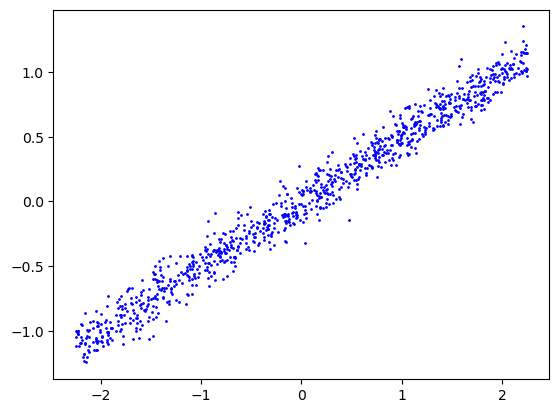

In [6]:
plt.scatter(x, y, color='blue', label='Data Points', s=1)

In [7]:
intervals = linearPredictionInterval(xtrain, ytrain, xtest, alpha)

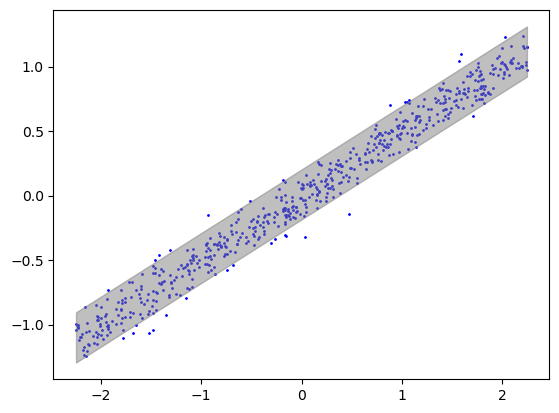

In [8]:
## plot prediction interval 
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')

In [9]:
cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.9483333333333334


### Experiment 2

* true model is nonlinear with heteroskedastic Gaussian noise
* we fit a linear model
* we use conformal prediction interval

In [10]:
x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

In [11]:
n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

regressor = LinearRegression().fit(xtrain1.reshape(-1, 1), ytrain1)
resids = ytrain2 - regressor.predict(xtrain2.reshape(-1, 1))

In [12]:
intervals = conformalInterval(resids, regressor.predict(xtest.reshape(-1, 1)), alpha)

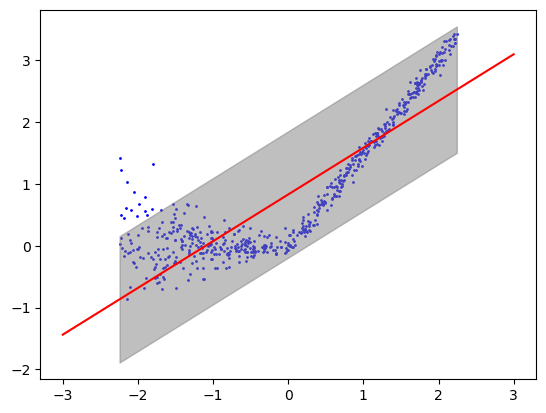

In [13]:
xlinspace = np.linspace(-3, 3, 1000)
ylinspace = regressor.predict(xlinspace.reshape(-1, 1))

## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]

plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.plot(xlinspace, ylinspace, color = 'red')
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')

In [14]:
cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.9733333333333334


### Experiment 3

* true model is nonlinear with heteroskedastic Gaussian noise
* we fit a nonlinear model
* we use conformal prediction interval with score = residual

In [15]:
x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

In [16]:
## train neural network on first half of training data

class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        return x.squeeze()
    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

model = NNet(1, 5)
lr = 0.1
epochs = 200
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train1)
    loss = criterion(y_pred, y_train1)
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()

    if epoch % 20 == 0:
        print('epoch', epoch, 'loss', f"{epoch_loss:.3}")


epoch 0 loss 1.33
epoch 20 loss 0.102
epoch 40 loss 0.0586
epoch 60 loss 0.0499
epoch 80 loss 0.0483
epoch 100 loss 0.048
epoch 120 loss 0.0479
epoch 140 loss 0.0478
epoch 160 loss 0.0478
epoch 180 loss 0.0477


In [17]:
## compute residues on second half of training data
## and prediction intervals on test data

x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)
resids = ytrain2 - model(x_train2).squeeze().detach().numpy() # scores on our calibration / D2 data

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
y_pred = model(x_test).squeeze().detach().numpy()  # f(X_new)

intervals = conformalInterval(resids, y_pred, alpha)   # f(X_new) +/- s_hat ((1-alpha)*(n+1)/n-quantile of abs(resids))

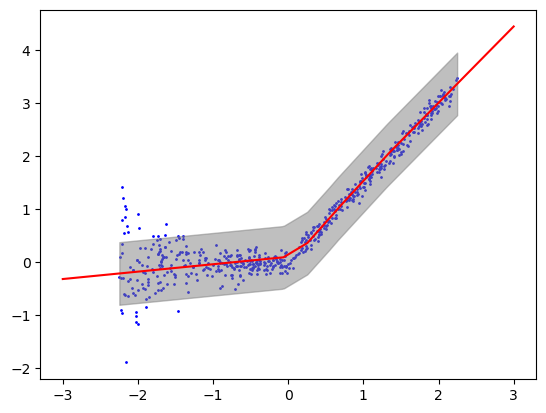

In [18]:
## plot f
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

xlinspace = np.linspace(-3, 3, 1000)
xlinspace_torch = torch.tensor(xlinspace, dtype=torch.float32).reshape(-1,1)
ylinspace = model(xlinspace_torch).squeeze().detach().numpy()

interval_grid = intervals[sorted_ix, :]

plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.plot(xlinspace, ylinspace, color = 'red')

plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')

In [19]:
cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.9566666666666667


## Experiment 4
* true model is nonlinear with heteroskedastic Gaussian noise
* we fit a nonlinear model with heteroskedastic noise
* we use a conformal prediction interval with score = studentized residual

In [20]:
x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

In [21]:
## train neural network on first half of training data

class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.mean_layer = nn.Linear(hidden_dim, 1)
        self.logvar_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)

        return mean.squeeze(), logvar.squeeze()
    
    def loss(self, x, mean, logvar):
        var = torch.exp(logvar)

        loss = torch.pow(x-mean, 2) / var + logvar
        out = loss.mean()
        return out
    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

model = NNet(1, 20)
lr = 0.01
epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()
    mean, logvar = model(x_train1)
    loss = model.loss(y_train1, mean, logvar)
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()

    if epoch % 20 == 0:
        print('epoch', epoch, 'loss', f"{epoch_loss:.3}")



epoch 0 loss 3.66
epoch 20 loss 0.401
epoch 40 loss -0.218
epoch 60 loss -1.25
epoch 80 loss -2.47
epoch 100 loss -2.6
epoch 120 loss -2.69
epoch 140 loss -2.75
epoch 160 loss -2.77
epoch 180 loss -2.78


In [22]:
def conformalResidueInterval(scores, mu, sigma, alpha):
    n = len(scores)
    t = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
    y_out_l = mu - t*sigma
    y_out_u = mu + t*sigma
    return np.hstack([y_out_l.reshape(-1, 1), y_out_u.reshape(-1, 1)])

In [23]:
## compute residues on second half of training data
## and prediction intervals on test data
x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)

mean, logvar = model(x_train2)
mean = mean.squeeze().detach().numpy()
logvar = logvar.squeeze().detach().numpy()

# compute scores 
resids = np.abs(ytrain2 - mean) / np.exp(0.5 * logvar)

# get mean and variance for intervals
x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
mean, logvar = model(x_test)
mean = mean.squeeze().detach().numpy()
logvar = logvar.squeeze().detach().numpy()
sd = np.exp(0.5 * logvar)

intervals = conformalResidueInterval(resids, mean, sd, alpha)

In [24]:
# note that this is larger than 1.96, which it would be if Gaussian assumption held
s_hat = np.quantile(resids, np.ceil((1-alpha)*(n+1))/n )
s_hat

np.float64(1.9150904429715403)

In [25]:
cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.955


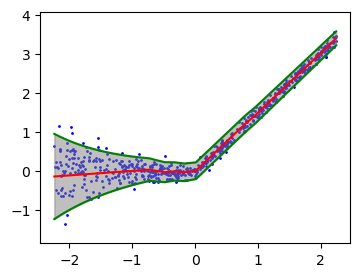

In [26]:
## plot f
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]

xlinspace = np.linspace(xgrid.min(), xgrid.max(), 1000)

xlinspace_torch = torch.tensor(xlinspace, dtype=torch.float32).reshape(-1,1)
mean_linspace, logvar_linspace = model(xlinspace_torch)
mean_linspace = mean_linspace.squeeze().detach().numpy()
sd_linspace = np.exp(0.5 * logvar_linspace.squeeze().detach().numpy())


plt.figure(figsize=(4, 3))
plt.ylim(ygrid.min()-0.5, ygrid.max()+0.5)

plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.plot(xlinspace, mean_linspace, 'r-')
plt.plot(xlinspace, mean_linspace + 1.96 * sd_linspace, 'g-')
plt.plot(xlinspace, mean_linspace - 1.96 * sd_linspace, 'g-')

plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')


Text(0.5, 1.0, 'Conformal prediction with studentized residuals $(\\widehat{s} = 1.92)$')

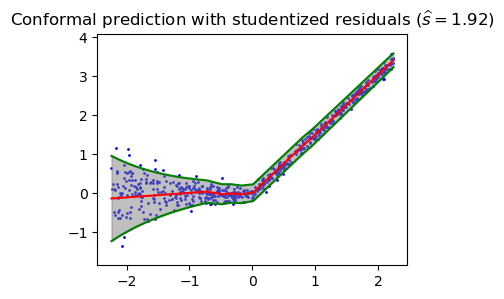

In [27]:
## plot f
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]

xlinspace = np.linspace(xgrid.min(), xgrid.max(), 1000)

xlinspace_torch = torch.tensor(xlinspace, dtype=torch.float32).reshape(-1,1)
mean_linspace, logvar_linspace = model(xlinspace_torch)
mean_linspace = mean_linspace.squeeze().detach().numpy()
sd_linspace = np.exp(0.5 * logvar_linspace.squeeze().detach().numpy())


plt.figure(figsize=(4, 3))
plt.ylim(ygrid.min()-0.5, ygrid.max()+0.5)

plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.plot(xlinspace, mean_linspace, 'r-')
plt.plot(xlinspace, mean_linspace + 1.96 * sd_linspace, 'g-')
plt.plot(xlinspace, mean_linspace - 1.96 * sd_linspace, 'g-')

plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')

plt.title('Conformal prediction with studentized residuals ' r'$(\widehat{{s}} = {:.2f})$'.format(s_hat))

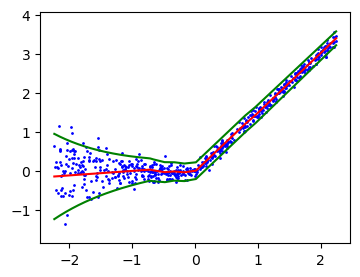

In [28]:
## plot f
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]

xlinspace = np.linspace(xgrid.min(), xgrid.max(), 1000)
xlinspace_torch = torch.tensor(xlinspace, dtype=torch.float32).reshape(-1,1)
mean_linspace, logvar_linspace = model(xlinspace_torch)
mean_linspace = mean_linspace.squeeze().detach().numpy()
sd_linspace = np.exp(0.5 * logvar_linspace.squeeze().detach().numpy())

plt.figure(figsize=(4, 3))
plt.ylim(ygrid.min()-0.5, ygrid.max()+0.5)
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.plot(xlinspace, mean_linspace, 'r-')
plt.plot(xlinspace, mean_linspace + 1.96 * sd_linspace, 'g-')
plt.plot(xlinspace, mean_linspace - 1.96 * sd_linspace, 'g-')